# Modelo de previsão do Ibovespa

## 01 - Importação das bibliotecas

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Bibliotecas

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error , r2_score, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import periodogram
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet

warnings.filterwarnings("ignore")

c:\Users\jdlma\Documents\GitHub\techalleg_fase_2\.venv\Lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\jdlma\Documents\GitHub\techalleg_fase_2\.venv\Lib\site-packages\statsforecast\utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


## 02 - Input dos dados

In [3]:
# Leitura do arquivo ** mostrar de onde veio o dado - 2005 até final de 2024

df = pd.read_csv('https://raw.githubusercontent.com/jdlmauricio/techalleg_fase_2/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv')


# Carregar os dados
url = 'https://raw.githubusercontent.com/jdlmauricio/techalleg_fase_2/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv'
indice_ibov = pd.read_csv(url, parse_dates=[0], index_col='Data')

## 03 - EDA (Exploratory Data Analysis)

In [4]:
# Visualizado dados ***

df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,30.12.2024,120.283,120.267,121.050,120.158,"8,90M","0,01%"
1,27.12.2024,120.269,121.078,121.609,120.252,"8,94M","-0,67%"
2,26.12.2024,121.078,120.767,121.612,120.428,"8,34M","0,26%"
3,23.12.2024,120.767,122.105,122.105,120.617,"9,95M","-1,09%"
4,20.12.2024,122.102,121.183,122.209,120.700,"18,13M","0,75%"


In [5]:
# Remove colunas desnecessárias ***
df = df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'])
# Renomeia colunas
df = df.rename(columns={'Data': 'ds', 'Último': 'y'})
# Converte coluna de data
df['ds'] = pd.to_datetime(df['ds'], format='%d.%m.%Y')
# Colocando a data como index
df = df.set_index('ds')

In [6]:
df.head(15)

,y
ds,
2024-12-30,120.283
2024-12-27,120.269
2024-12-26,121.078
2024-12-23,120.767
2024-12-20,122.102
2024-12-19,121.188
2024-12-18,120.772
2024-12-17,124.698
2024-12-16,123.560


In [7]:
df.tail(15)

,y
ds,
2005-01-21,23.818
2005-01-20,23.610
2005-01-19,24.271
2005-01-18,24.089
2005-01-17,24.515
2005-01-14,24.924
2005-01-13,24.806
2005-01-12,24.510
2005-01-11,24.370


In [8]:
# Criando uma série completa com finais de semana e feriados ***
datas_completas = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(datas_completas)

In [9]:
## Preenchendo valores ausentes com o último valor conhecido (forward-fill) ***
df['y'] = df['y'].fillna(method='ffill')

In [10]:
df.dtypes

y    float64
dtype: object

In [11]:
df.describe()

,y
count,7302.000000
mean,72.153192
std,29.048990
min,23.610000
25%,51.713750
50%,63.098000
75%,99.048750
max,137.344000


In [12]:
df.info

<bound method DataFrame.info of                   y
2005-01-03   25.722
2005-01-04   24.848
2005-01-05   24.692
2005-01-06   24.367
2005-01-07   24.747
...             ...
2024-12-26  121.078
2024-12-27  120.269
2024-12-28  120.269
2024-12-29  120.269
2024-12-30  120.283

[7302 rows x 1 columns]>

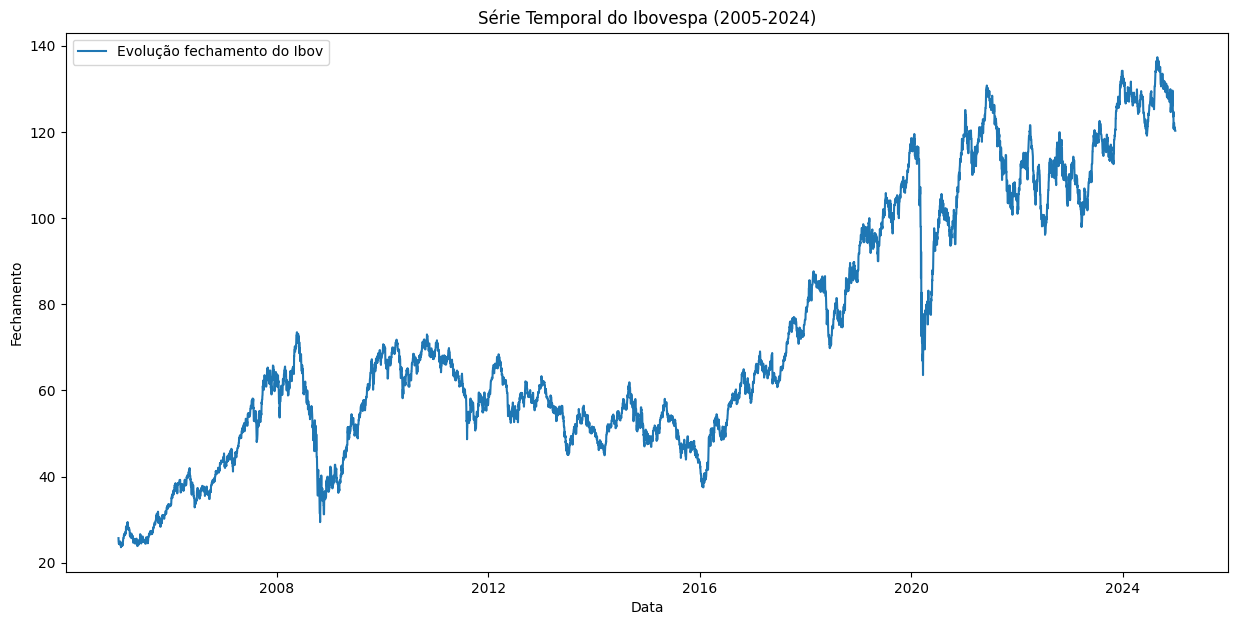

In [13]:
# plot da série temporal ***

plt.figure(figsize=(15, 7))
plt.plot(df.index, df['y'], label="Evolução fechamento do Ibov")
plt.title("Série Temporal do Ibovespa (2005-2024)")
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.legend()
plt.show()

### 3.1 Decomposição da série Temporal

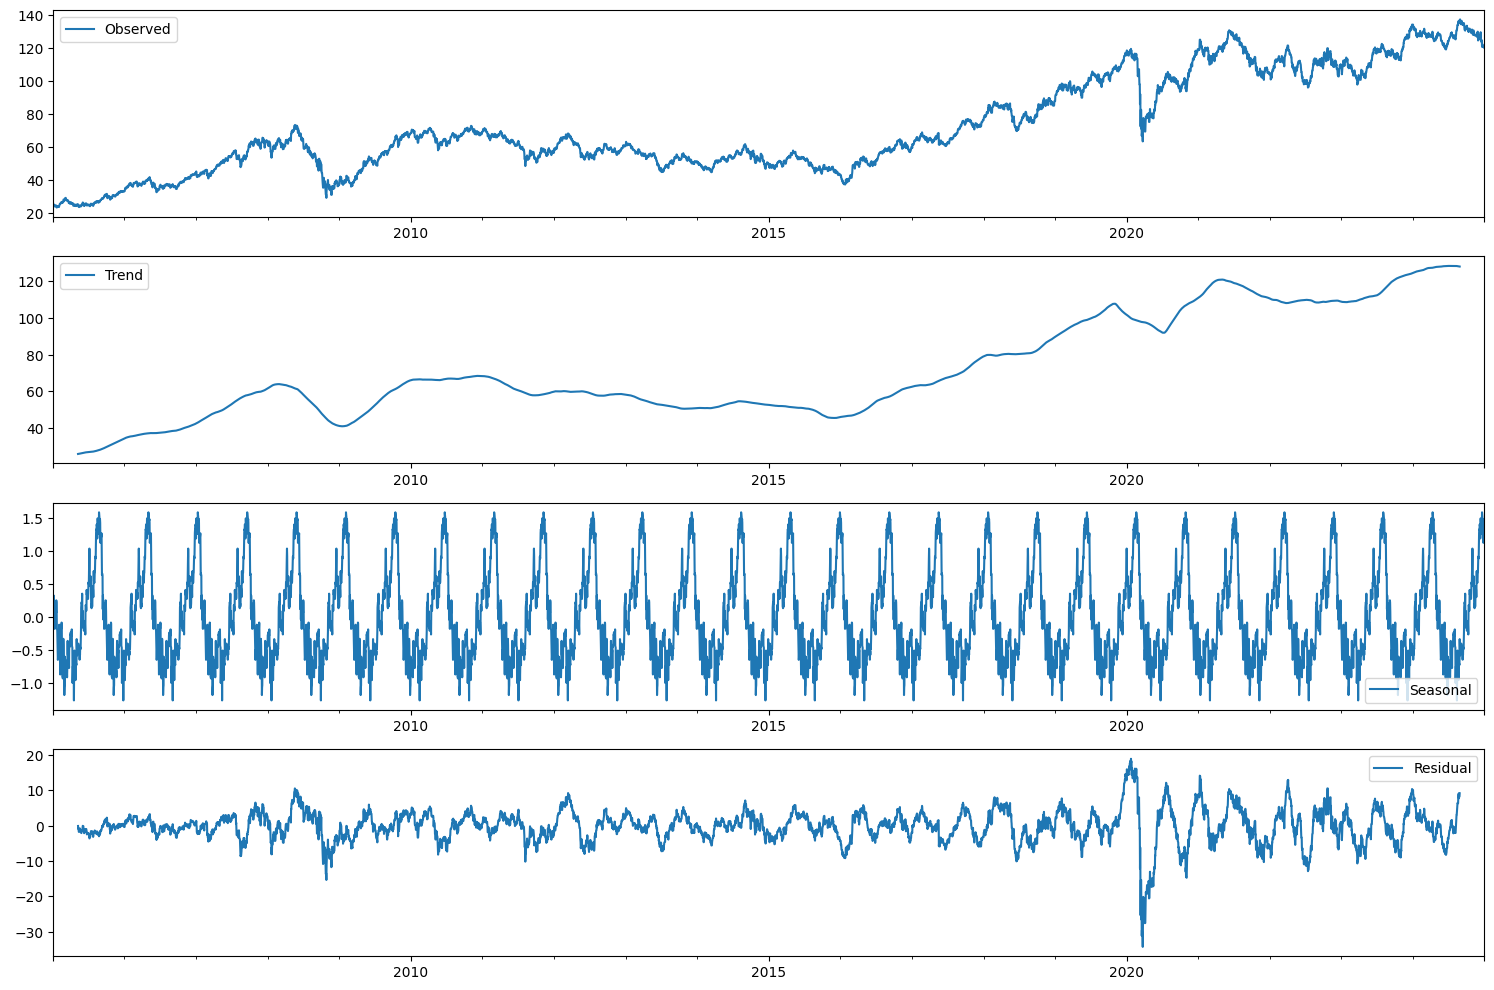

In [14]:
# Analisando a decomposição da série temporal (Método: decomposição aditiva) ***

detalhamento = seasonal_decompose(df["y"], model="additive", period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plotando a decomposição

detalhamento.observed.plot(ax=ax1, label='Observed')
detalhamento.trend.plot(ax=ax2, label='Trend')
detalhamento.seasonal.plot(ax=ax3, label='Seasonal')
detalhamento.resid.plot(ax=ax4, label='Residual')

# Adicionando as legendas
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

## 04 - Modelos

### 4.1 Separação de base de treino e validação

In [15]:
# Definindo WMAPE (não existe na biblioteca do sklearn)

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [16]:
df = df.reset_index()
df
df['unique_id'] = 0

In [17]:
df.rename(columns={'index': 'ds'}, inplace=True)

In [18]:
df.head()

,ds,y,unique_id
0,2005-01-03,25.722,0
1,2005-01-04,24.848,0
2,2005-01-05,24.692,0
3,2005-01-06,24.367,0
4,2005-01-07,24.747,0


In [19]:
df.dtypes

ds           datetime64[ns]
y                   float64
unique_id             int64
dtype: object

In [20]:
# Definição de período de Treino e validação ***

treino = df.loc[(df['ds'] >= '2021-01-01') & (df['ds'] < '2024-01-01')]

valid = df.loc[(df['ds'] >= '2024-01-01') & (df['ds'] < '2024-01-16')]

h = valid['ds'].nunique() # Quantidade de dias a serem previstos

In [21]:
h

15

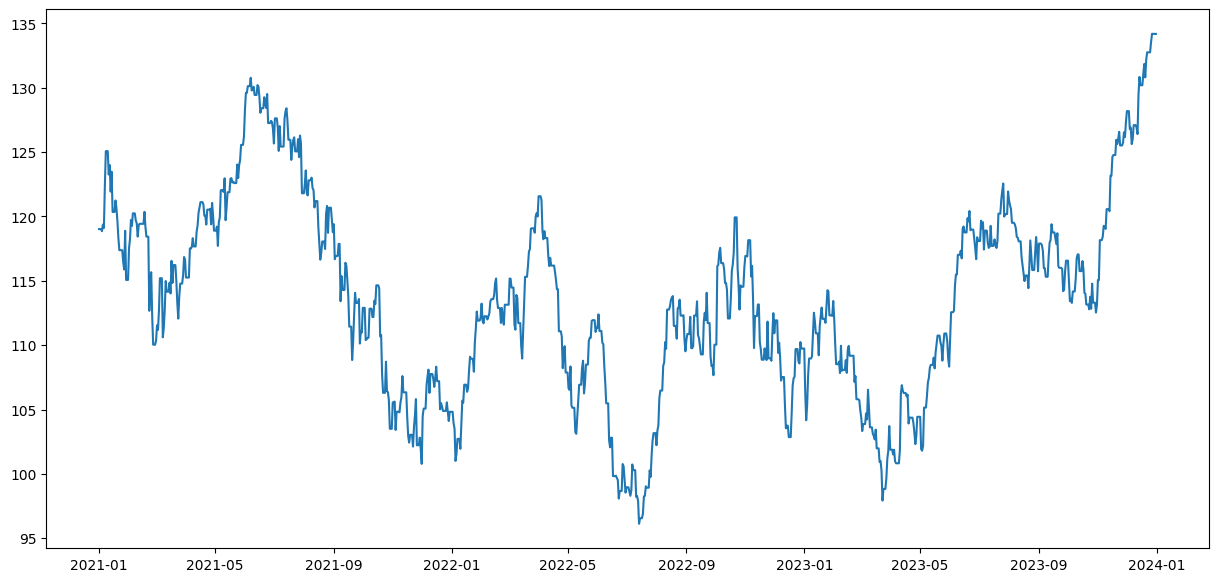

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(treino['ds'], treino['y'], label='Treino')

In [23]:
treino.describe()

,ds,y,unique_id
count,1095,1095.000000,1095.0
mean,2022-07-02 00:00:00,113.629765,0.0
min,2021-01-01 00:00:00,96.121000,0.0
25%,2021-10-01 12:00:00,108.223000,0.0
50%,2022-07-02 00:00:00,113.283000,0.0
75%,2023-04-01 12:00:00,118.858500,0.0
max,2023-12-31 00:00:00,134.194000,0.0
std,NaN,7.735516,0.0


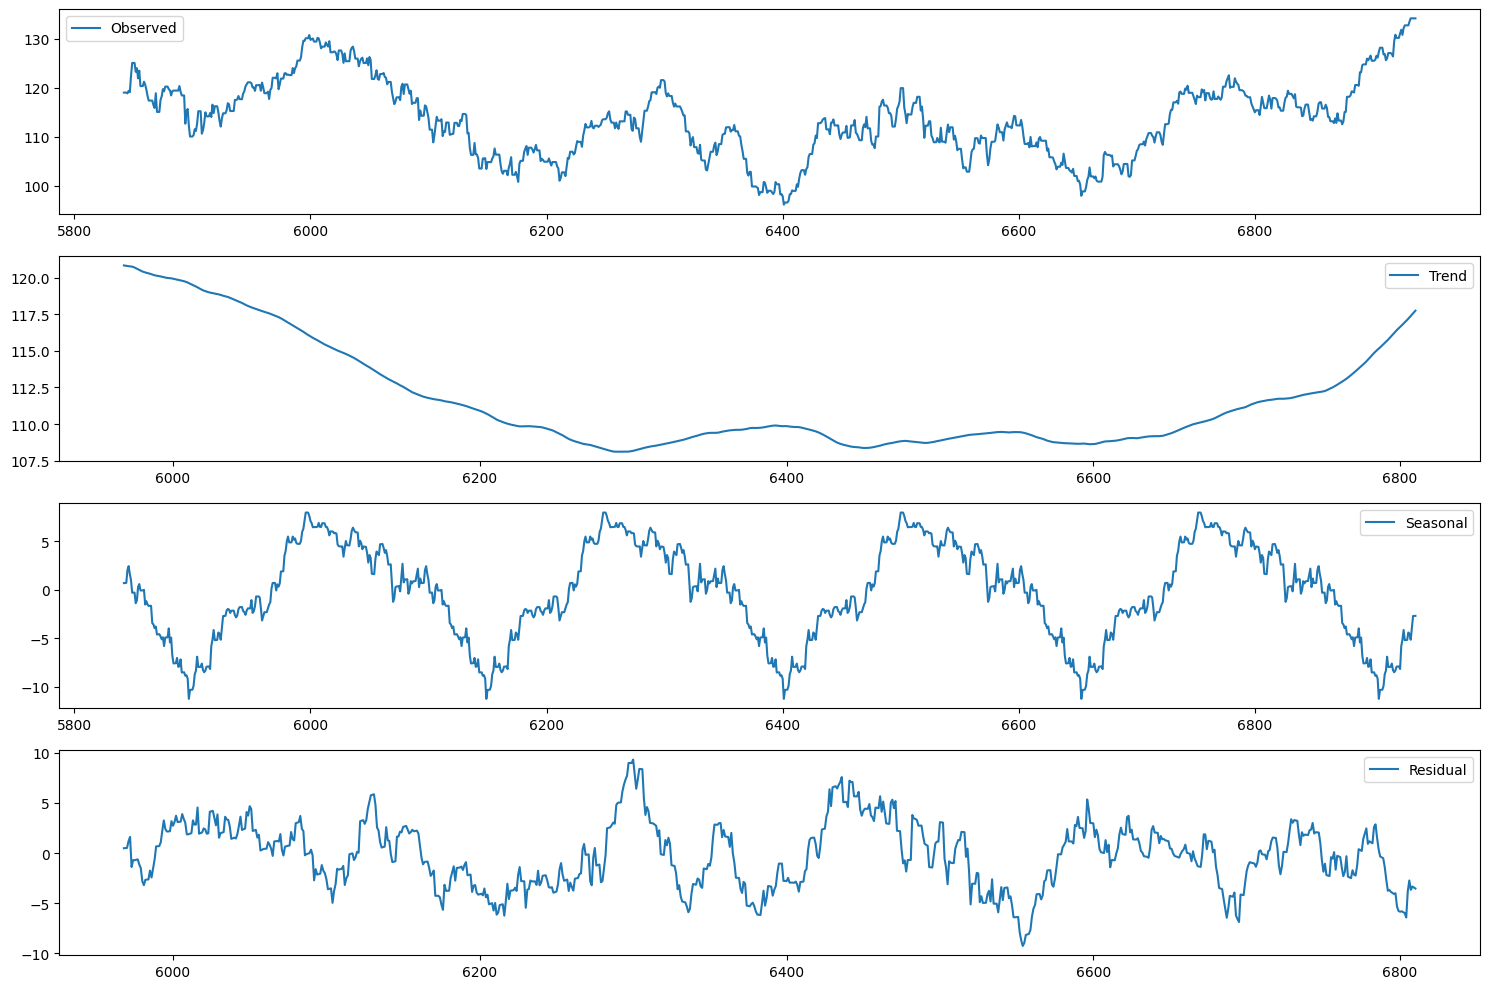

In [24]:
# Analisando a decomposição da série temporal (Método: decomposição aditiva)

detalhamento1 = seasonal_decompose(treino["y"], model="additive", period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plotando a decomposição

detalhamento1.observed.plot(ax=ax1, label='Observed')
detalhamento1.trend.plot(ax=ax2, label='Trend')
detalhamento1.seasonal.plot(ax=ax3, label='Seasonal')
detalhamento1.resid.plot(ax=ax4, label='Residual')

# Adicionando as legendas
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

In [25]:
# Número de dias a serem previstos

h

15

### 4.2 - Naive - Baseline

In [26]:
#Escolha do modelo, períodocidade dos dados e número de processadores

naive_model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1) # n_jobs é uma vairavel que determinando o número de processadores que serão utilizados, o -1 é para utilizar todos os processadores

#Treinando o modelo

naive_model.fit(treino)

# definindo o período de previsão e o intervalo de confiança

forecast_naive = naive_model.predict(h=h, level=[90]) # level identifica o intervalo de confiança, ou sej o nível de probabilidade de acerto

In [27]:
# Unindo o dataset de previsão com o dataset de validação

forecast_naive = forecast_naive.reset_index().merge(valid, on=['ds','unique_id'], how='left')

In [28]:
forecast_naive

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,0,2024-01-01,134.184998,132.278748,136.091248,134.185
1,0,2024-01-02,134.184998,131.489166,136.880829,132.697
2,0,2024-01-03,134.184998,130.883286,137.486710,132.834
3,0,2024-01-04,134.184998,130.372513,137.997482,131.226
4,0,2024-01-05,134.184998,129.922501,138.447495,132.023
5,0,2024-01-06,134.184998,129.515671,138.854324,132.023
6,0,2024-01-07,134.184998,129.141556,139.228439,132.023
7,0,2024-01-08,134.184998,128.793320,139.576675,132.427
8,0,2024-01-09,134.184998,128.466263,139.903732,131.447
9,0,2024-01-10,134.184998,128.156921,140.213074,130.841


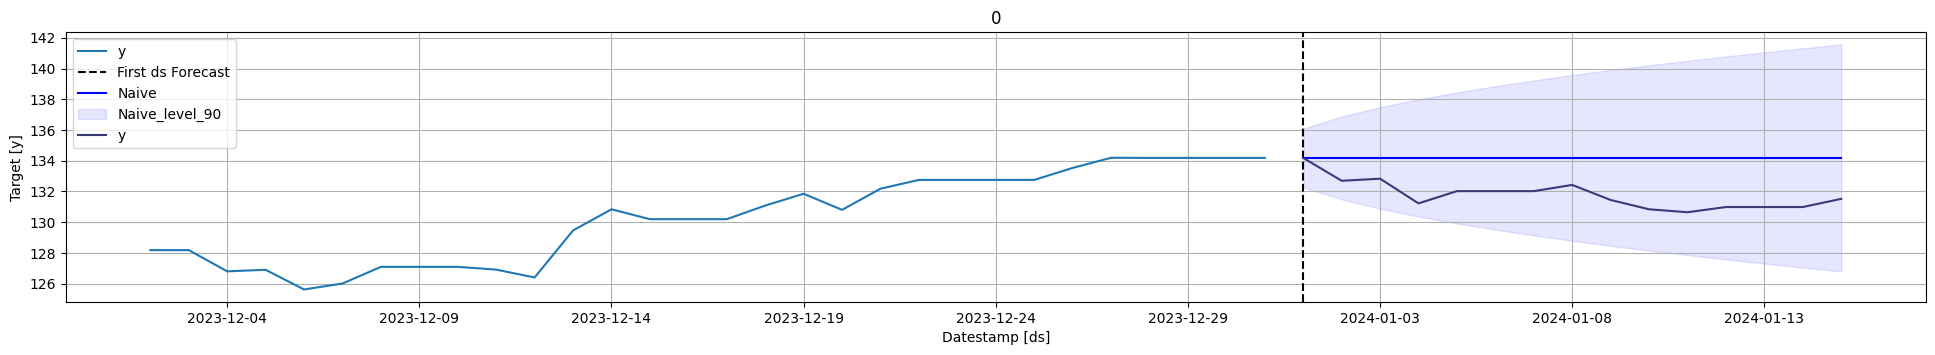

In [29]:
# Plotando o gráfico de previsão com histórico de 1 ano e previsão de 30 dias ***

naive_model.plot(treino, forecast_naive, level=[90],engine ='matplotlib', max_insample_length=30)

In [30]:
# Avaliação do modelo *** Resultado com foco no resultado do print

mae_naive = mean_absolute_error(forecast_naive['y'], forecast_naive['Naive'])
print(f'MAE Naive Baseline: {mae_naive}')

rmse_naive = root_mean_squared_error(forecast_naive['y'], forecast_naive['Naive'])
print(f'rmse Naive Baseline: {rmse_naive}')

mape_naive = mean_absolute_percentage_error(forecast_naive['y'], forecast_naive['Naive'])
print(f'MAPE Naive Baseline: {mape_naive}')

wmape_naive = wmape(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'WMAPE Naive Baseline: {wmape_naive:.2%}')

mse_naive = mean_squared_error(forecast_naive['y'], forecast_naive['Naive'])
print(f'MSE Naive Baseline: {mse_naive}')

r2_naive = r2_score(forecast_naive['y'], forecast_naive['Naive'])
print(f'R² Naive Baseline: {r2_naive}')

MAE Naive Baseline: 2.394331217447918
rmse Naive Baseline: 2.567096227697468
MAPE Naive Baseline: 0.018217591255696986
WMAPE Naive Baseline: 1.82%
MSE Naive Baseline: 6.589983042258569
R² Naive Baseline: -6.688136266574274


### 4.3 - Seasonal Window Average

In [31]:
#Escolha do modelo, períodocidade dos dados e número de processadores

# Definido média móvel de 2 dias e com sazonalidade de 21 dias

swa_model = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2)], freq='D', n_jobs=-1) # n_jobs é uma vairavel que determinando o número de processadores que serão utilizados, o -1 é para utilizar todos os processadores

#Treinando o modelo

swa_model.fit(treino)

# definindo o período de previsão e o intervalo de confiança

forecast_swa = swa_model.predict(h=h, level=[90]) # level identifica o intervalo de confiança, ou sej o nível de probabilidade de acerto

In [32]:
# Unindo o dataset de previsão com o dataset de validação

forecast_swa = forecast_swa.reset_index().merge(valid, on=['ds','unique_id'], how='left')

In [33]:
forecast_swa.head()

,unique_id,ds,SeasWA,y
0,0,2024-01-01,131.918503,134.185
1,0,2024-01-02,132.692001,132.697
2,0,2024-01-03,132.498993,132.834
3,0,2024-01-04,133.183502,131.226
4,0,2024-01-05,133.468994,132.023


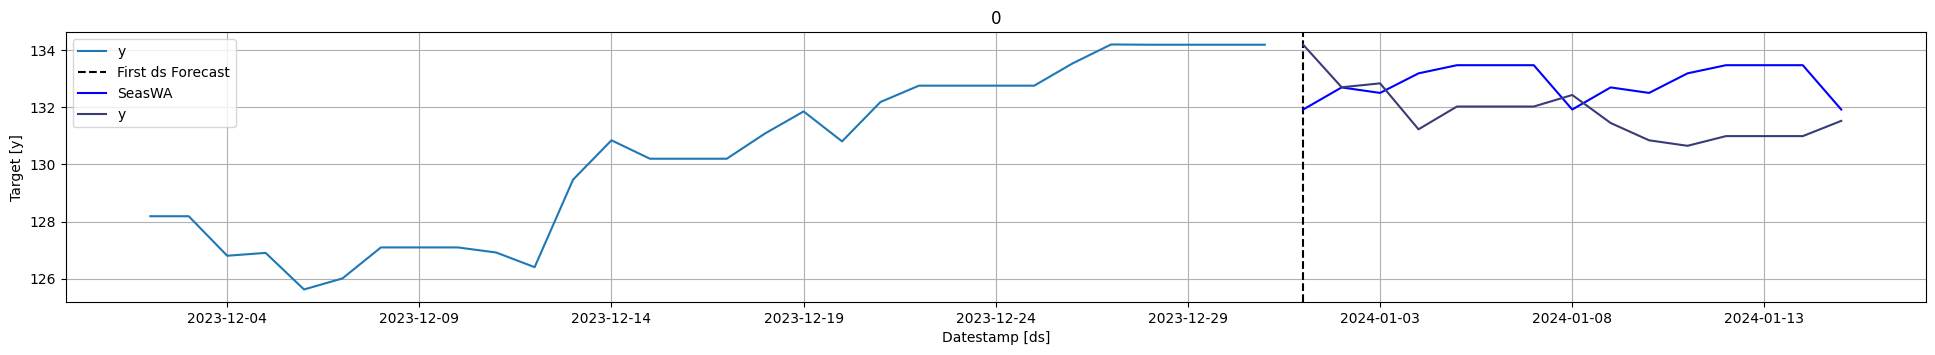

In [34]:
# Plotando o gráfico de previsão com histórico de 1 ano e previsão de 90 dias ***

swa_model.plot(treino, forecast_swa, level=[90],engine ='matplotlib', max_insample_length=30)

In [35]:
# Avaliação do modelo *** Resultado com foco no resultado do print

mae_swa = mean_absolute_error(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'MAE swa : {mae_swa}')

rmse_swa = root_mean_squared_error(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'rmse swa : {rmse_swa}')

mape_swa = mean_absolute_percentage_error(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'MAPE swa : {mape_swa}')

wmape_swa = wmape(forecast_swa['y'].values, forecast_swa['SeasWA'].values)
print(f'WMAPE swa : {wmape_swa:.2%}')

mse_swa = mean_squared_error(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'MSE swa : {mse_swa}')

r2_swa = r2_score(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'R² swa : {r2_swa}')

MAE swa : 1.5125644287109385
rmse swa : 1.7312619708939774
MAPE swa : 0.011496800549552691
WMAPE swa : 1.15%
MSE swa : 2.997268011863699
R² swa : -2.496732048456784


In [36]:
#Escolha do modelo, períodocidade dos dados e número de processadores

# Definido média móvel de 21 dias corridos e com sazonalidade trimestral

a_arima_model = StatsForecast(models=[AutoARIMA(season_length=730)], freq='D', n_jobs=-1) # n_jobs é uma vairavel que determinando o número de processadores que serão utilizados, o -1 é para utilizar todos os processadores

#Treinando o modelo

a_arima_model.fit(treino)

# definindo o período de previsão e o intervalo de confiança

forecast_a_arima = a_arima_model.predict(h=h, level=[90]) # level identifica o intervalo de confiança, ou sej o nível de probabilidade de acerto

In [37]:
# Unindo o dataset de previsão com o dataset de validação

forecast_a_arima = forecast_a_arima.reset_index().merge(valid, on=['ds','unique_id'], how='left')

In [38]:
forecast_a_arima.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,0,2024-01-01,134.184998,132.277878,136.092117,134.185
1,0,2024-01-02,134.184998,131.487915,136.882080,132.697
2,0,2024-01-03,134.184998,130.881760,137.488235,132.834
3,0,2024-01-04,134.184998,130.370743,137.999252,131.226
4,0,2024-01-05,134.184998,129.920532,138.449463,132.023


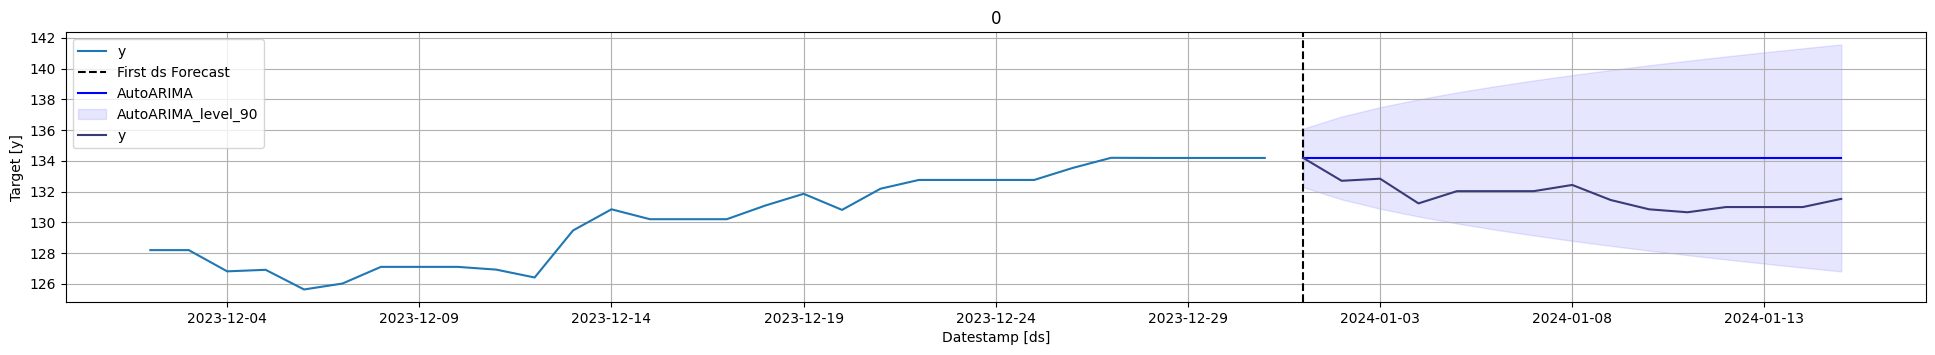

In [39]:
# Plotando o gráfico de previsão com histórico de 1 ano e previsão de 90 dias

a_arima_model.plot(treino, forecast_a_arima, level=[90],engine ='matplotlib', max_insample_length=30)

In [40]:
# Avaliação do modelo Arima

mae_a_arima = mean_absolute_error(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'MAE a_arima : {mae_a_arima}')

rmse_a_arima = root_mean_squared_error(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'MAPE a_arima : {rmse_a_arima}')

mape_a_arima = mean_absolute_percentage_error(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'MAPE a_arima : {mape_a_arima}')

wmape_a_arima = wmape(forecast_a_arima['y'].values, forecast_a_arima['AutoARIMA'].values)
print(f'WMAPE a_arima : {wmape_a_arima:.2%}')

mse_a_arima = mean_squared_error(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'MSE a_arima : {mse_a_arima}')

r2_a_arima = r2_score(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'R² a_arima : {r2_a_arima}')

MAE a_arima : 2.394331217447918
MAPE a_arima : 2.567096227697468
MAPE a_arima : 0.018217591255696986
WMAPE a_arima : 1.82%
MSE a_arima : 6.589983042258569
R² a_arima : -6.688136266574274


### 4.4 - Sarima

#### 4.4.1 - Feature Engineering

##### 4.4.1.1 - Estacionarização da série

In [41]:
df_arima_valid = valid.copy()

In [42]:
# Remove colunas desnecessárias
df_arima_valid = df_arima_valid.drop(columns=['unique_id'])
# Colocando a data como index
df_arima_valid = df_arima_valid.set_index('ds')

In [43]:
df_arima_valid.head()

,y
ds,
2024-01-01,134.185
2024-01-02,132.697
2024-01-03,132.834
2024-01-04,131.226
2024-01-05,132.023


In [44]:
df_arima = treino.copy()

In [45]:
# Remove colunas desnecessárias
df_arima = df_arima.drop(columns=['unique_id'])
# Colocando a data como index
df_arima = df_arima.set_index('ds')

In [46]:
df_arima.head()

,y
ds,
2021-01-01,119.017
2021-01-02,119.017
2021-01-03,119.017
2021-01-04,118.855
2021-01-05,119.376


In [47]:
df_arima.dtypes

y    float64
dtype: object

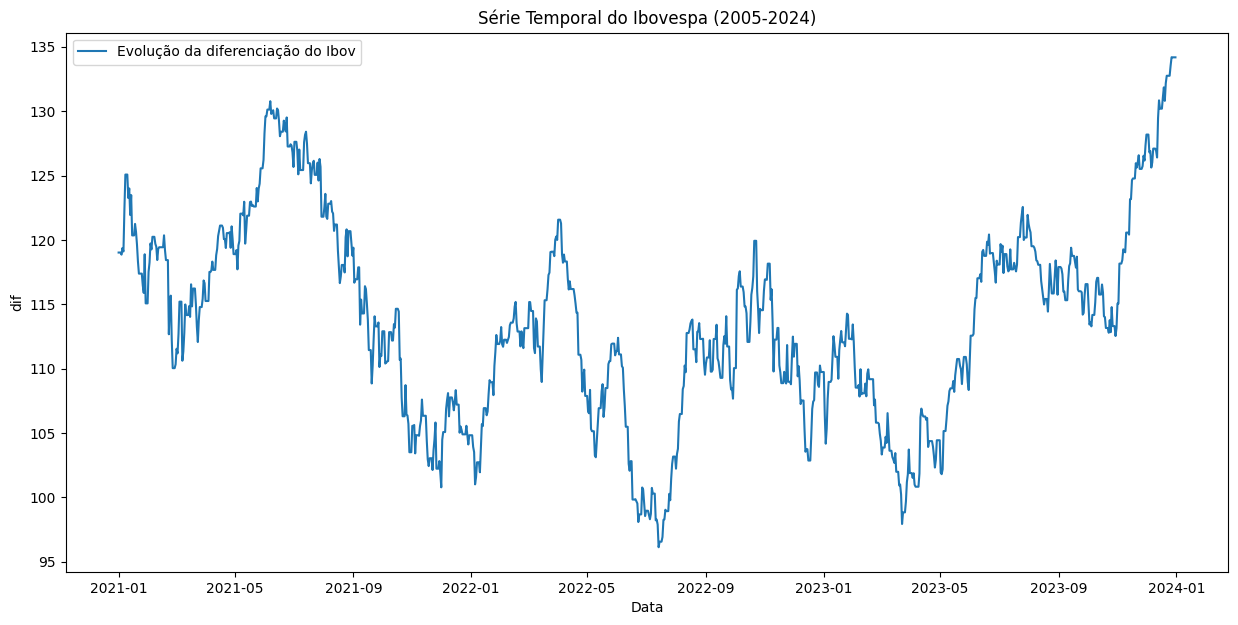

In [48]:
# Plot do dado: ***

plt.figure(figsize=(15, 7))
plt.plot(df_arima.index, df_arima["y"], label="Evolução da diferenciação do Ibov")
plt.title("Série Temporal do Ibovespa (2005-2024)")
plt.xlabel("Data")
plt.ylabel("dif")
plt.legend()
plt.show()

In [49]:
# Testando a Estacionariedade ***
    # Teste de Dickey-fuller Aumentado (ADF)

# Teste ADF
resultado_adf = adfuller(df_arima["y"].dropna())
print(f"Estatística ADF: {resultado_adf[0]}")
print(f"Valor-p: {resultado_adf[1]:.15e}")
for key, value in resultado_adf[4].items():
    print(f"Valor Crítico {key}: {value}")

# Interpretação
if resultado_adf[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística ADF: -1.8202703522041503
Valor-p: 3.704454724514135e-01
Valor Crítico 1%: -3.436341508283391
Valor Crítico 5%: -2.864185524365606
Valor Crítico 10%: -2.5681785627437677
A série não é estacionária.


Método da Diferenciação de primeira Ordem

In [50]:
# Estacionarização da Série (Método: Diferenciação) ***

# Criando coluna com diferenciação do dado corrente e dado shiftado
df_arima['dif'] = df_arima['y'] - df_arima['y'].shift(1)
df_arima = df_arima.dropna()  # Remova os valores NaN gerados pela diferenciação

In [51]:
df_arima.head()

,y,dif
ds,,
2021-01-02,119.017,0.000
2021-01-03,119.017,0.000
2021-01-04,118.855,-0.162
2021-01-05,119.376,0.521
2021-01-06,119.100,-0.276


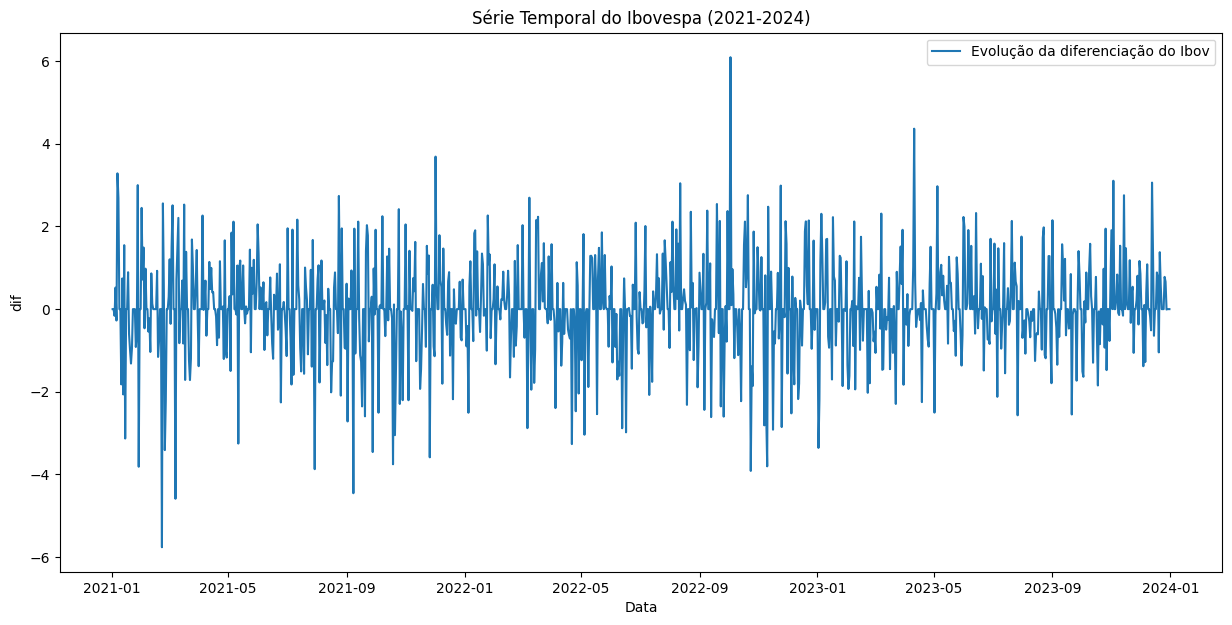

In [52]:
# Plot do dado Diferenciado: ***

plt.figure(figsize=(15, 7))
plt.plot(df_arima.index, df_arima["dif"], label="Evolução da diferenciação do Ibov")
plt.title("Série Temporal do Ibovespa (2021-2024)")
plt.xlabel("Data")
plt.ylabel("dif")
plt.legend()
plt.show()

In [53]:
# Testando a Estacionariedade ***
    # Teste de Dickey-fuller Aumentado (ADF)

# Teste ADF
resultado_adf_dif = adfuller(df_arima["dif"].dropna())
print(f"Estatística ADF: {resultado_adf_dif[0]}")
print(f"Valor-p: {resultado_adf_dif[1]:.15e}")
for key, value in resultado_adf_dif[4].items():
    print(f"Valor Crítico {key}: {value}")

# Interpretação
if resultado_adf_dif[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística ADF: -34.05600258611855
Valor-p: 0.000000000000000e+00
Valor Crítico 1%: -3.4363470029475525
Valor Crítico 5%: -2.864187948086107
Valor Crítico 10%: -2.568179853605536
A série é estacionária.


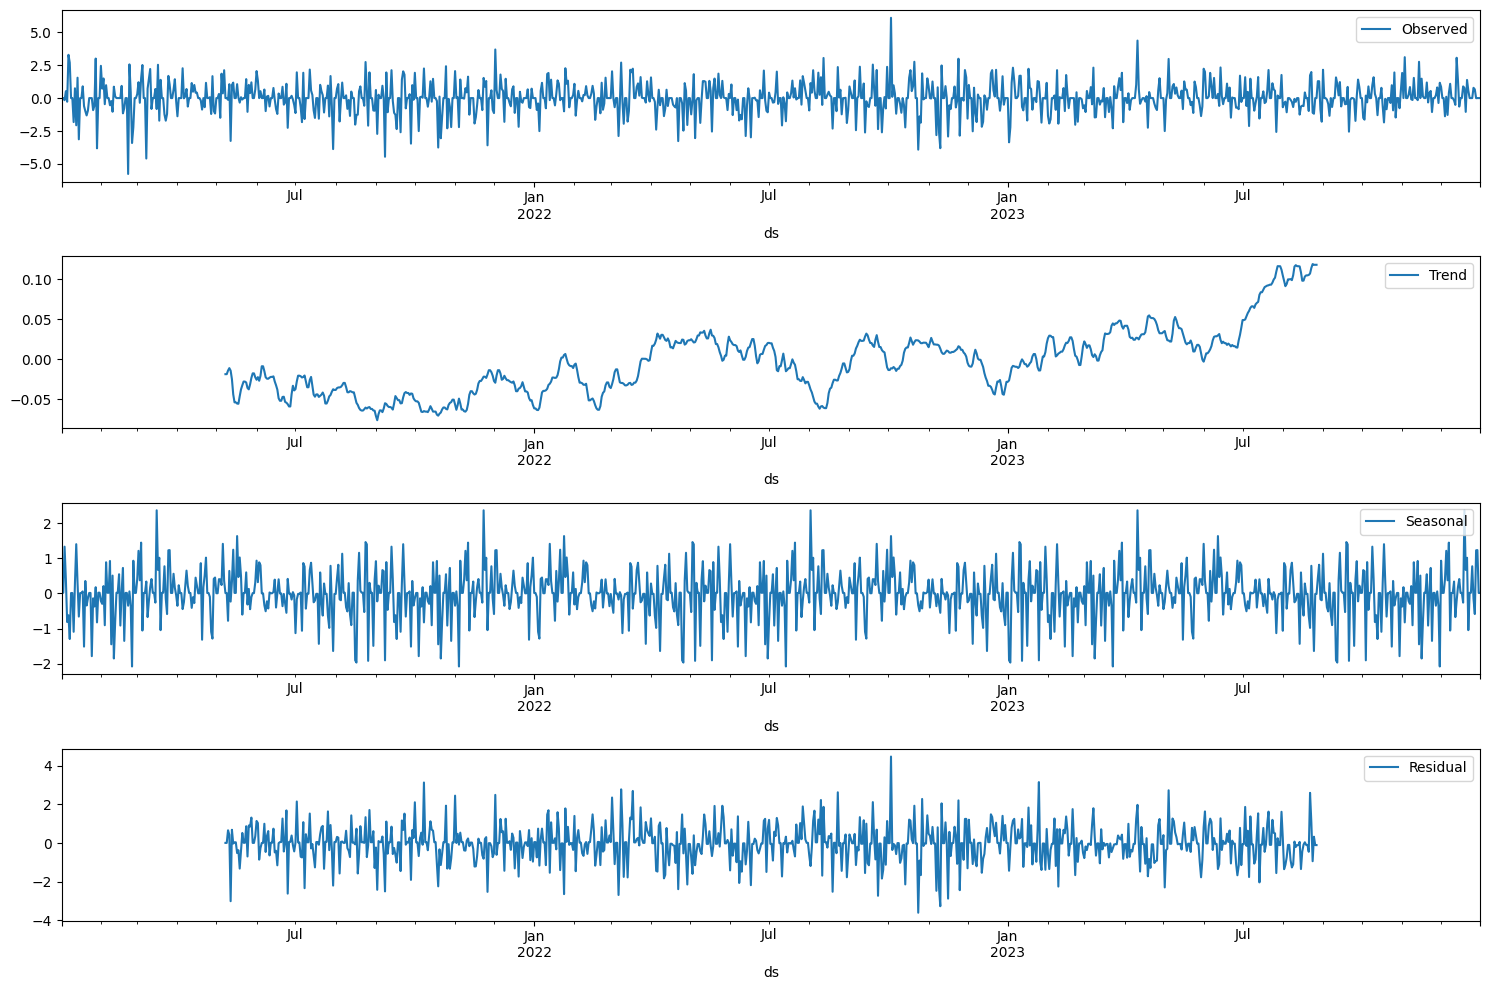

In [54]:
# Analisando a decomposição da série temporal (Método: decomposição aditiva)

detalhamento2 = seasonal_decompose(df_arima["dif"], model="additive", period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plotando a decomposição

detalhamento2.observed.plot(ax=ax1, label='Observed')
detalhamento2.trend.plot(ax=ax2, label='Trend')
detalhamento2.seasonal.plot(ax=ax3, label='Seasonal')
detalhamento2.resid.plot(ax=ax4, label='Residual')

# Adicionando as legendas
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

##### 4.4.1.2 - Identificação dos parâmetros para o modelo

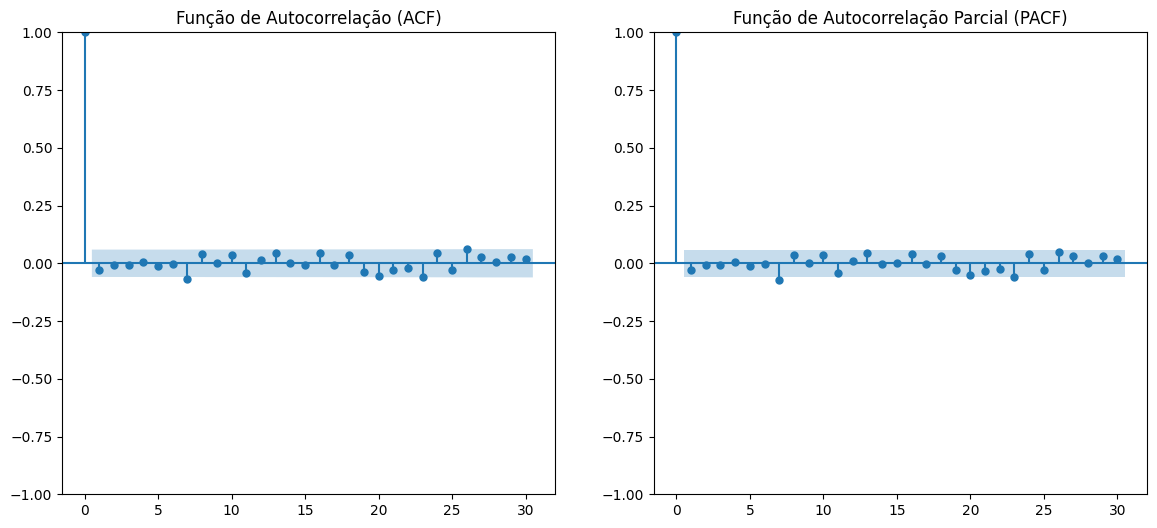

In [55]:
# Identificação dos Parâmetros do Modelo ARIMA - PACF - AR (AutoRegressivo): p, I (Integrado): d, ACF - MA (Média Móvel): q ***

# Plot da ACF e PACF da série diferenciada

plt.figure(figsize=(14, 6))

#Plot ACF: q
plt.subplot(121)
plot_acf(df_arima["dif"].dropna(), ax=plt.gca(), lags=30)
plt.title("Função de Autocorrelação (ACF)")

#Plot PACF: p
plt.subplot(122)
plot_pacf(df_arima["dif"].dropna(), ax=plt.gca(), lags=30)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()

In [56]:
p = 1 # compentente AR ***
d = 1 # Componente I
q = 1 # Componente MA

In [57]:
# Ajuste do modelo ARIMA(p, d, q)

# Suposição: p=2, d=1, q=2 (com base na análise dos gráficos ACF e PACF)

model_arima = ARIMA(df_arima["dif"], order=(p, d, q))
resultado_arima = model_arima.fit()

# Resumo do modelo
print(resultado_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                    dif   No. Observations:                 1094
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1715.534
Date:                Tue, 21 Jan 2025   AIC                           3437.069
Time:                        20:34:41   BIC                           3452.059
Sample:                    01-02-2021   HQIC                          3442.742
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0298      0.030     -1.003      0.316      -0.088       0.028
ma.L1         -0.9990      0.011    -90.523      0.000      -1.021      -0.977
sigma2         1.3440      0.040     33.318      0.0

In [58]:
# Previsão dos próximos 91 dias
forecast_arima = resultado_arima.forecast(steps=15)

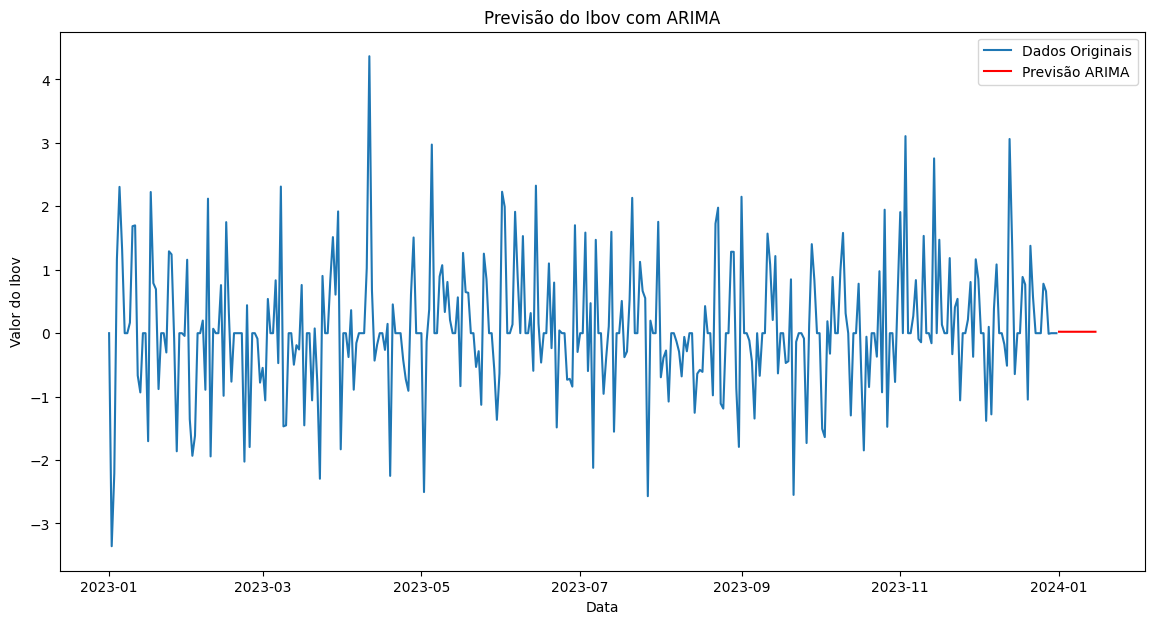

In [59]:
# Plot das previsões
plt.figure(figsize=(14, 7))
plt.plot(df_arima["dif"].iloc[-365:], label="Dados Originais")
plt.plot(forecast_arima.index, forecast_arima, color="red", label="Previsão ARIMA")
plt.title("Previsão do Ibov com ARIMA")
plt.xlabel("Data")
plt.ylabel("Valor do Ibov")
plt.legend()
plt.show()

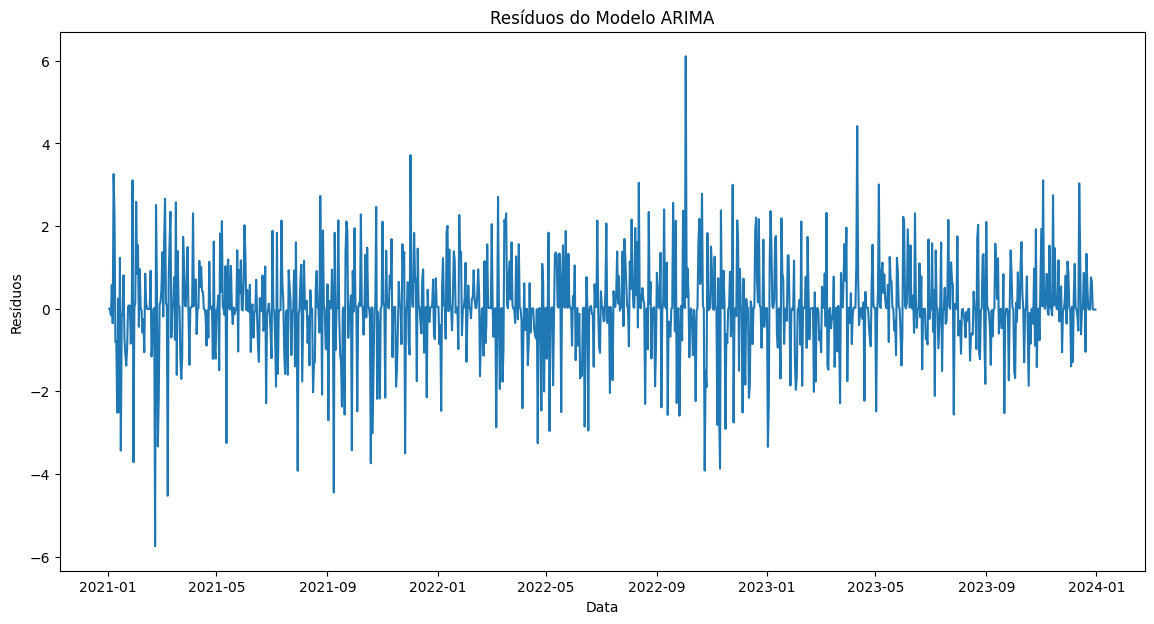

,lb_stat,lb_pvalue
10,8.409967,0.588858


In [60]:
# Resíduos do modelo ARIMA
resid_arima = resultado_arima.resid

# Plot dos resíduos
plt.figure(figsize=(14, 7))
plt.plot(resid_arima)
plt.title("Resíduos do Modelo ARIMA")
plt.xlabel("Data")
plt.ylabel("Resíduos")
plt.show()

# Teste de Ljung-Box
lb_test = acorr_ljungbox(resid_arima, lags=[10], return_df=True)
lb_test

In [61]:
# Avaliação do modelo

mae_arima = mean_absolute_error(df_arima_valid, forecast_arima)
print(f'MAE arima : {mae_arima}')

rmse_arima = root_mean_squared_error(df_arima_valid, forecast_arima)
print(f'MAPE arima : {rmse_arima}')

mape_arima = mean_absolute_percentage_error(df_arima_valid, forecast_arima)
print(f'MAPE arima : {mape_arima}')

mse_arima = mean_squared_error(df_arima_valid, forecast_arima)
print(f'MSE arima : {mse_arima}')

r2_arima = r2_score(df_arima_valid, forecast_arima)
print(f'R² arima : {r2_arima}')

MAE arima : 131.76807208985488
MAPE arima : 131.77132378646124
MAPE arima : 0.9998285546991355
MSE arima : 17363.68177243641
R² arima : -20256.161619367507


### 4.5 - Previsão do modelo Samira

In [62]:
s = 21 # assumindo sazonalidade de 21 dias **

model_sarima = SARIMAX(df_arima['dif'], 
                order=(1, 1, 1), # Parâmetros pelo ACF e PACF
                seasonal_order=(1, 1, 1, s)) # Parâmetros sazonais
resultado_sarima = model_sarima.fit(disp=False)


# Resumo do modelo
print(resultado_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                dif   No. Observations:                 1094
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 21)   Log Likelihood               -1725.822
Date:                            Tue, 21 Jan 2025   AIC                           3461.643
Time:                                    20:34:47   BIC                           3486.530
Sample:                                01-02-2021   HQIC                          3471.070
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0331      0.032     -1.045      0.296      -0.095       0.029
ma.L1         -0.9998      0.164   

In [63]:
# Modelo SARIMA com dados de treino
forecast_sarima_train = resultado_sarima.forecast(steps=15)

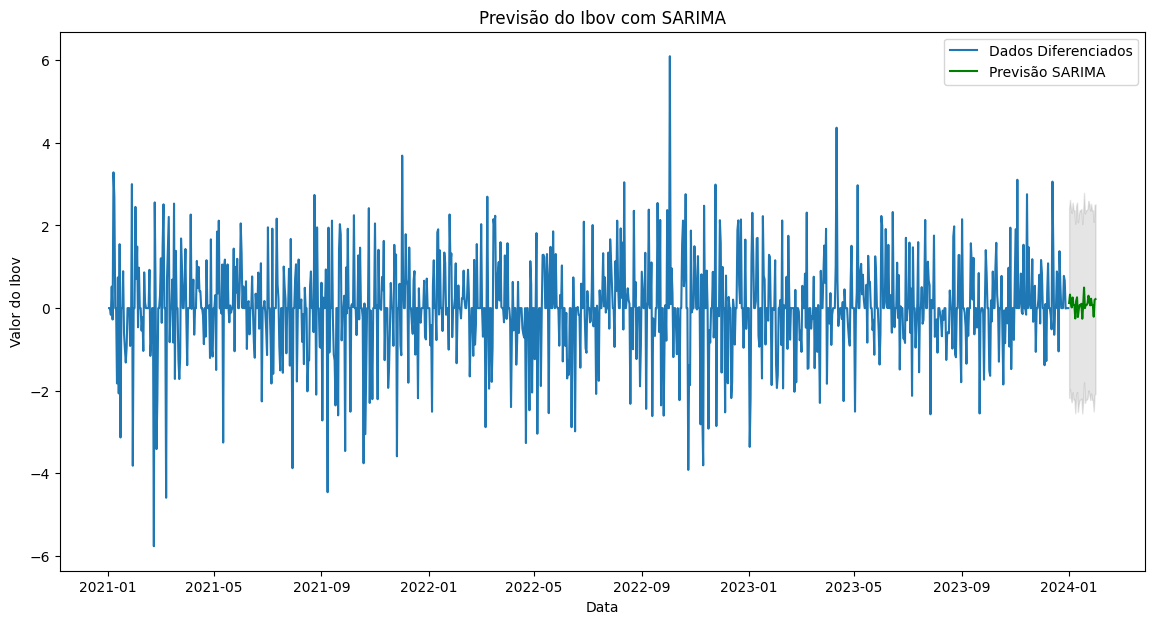

In [64]:
# # Previsão dos próximos 15 dias ***
forecast_sarima = resultado_sarima.get_forecast(steps=31)
forecast_sarima_mean = forecast_sarima.predicted_mean
forecast_sarima_conf_int = forecast_sarima.conf_int()

# Plot das previsões
plt.figure(figsize=(14, 7))
plt.plot(df_arima["dif"], label="Dados Diferenciados")
plt.plot(
    forecast_sarima_mean.index,
    forecast_sarima_mean,
    color="green",
    label="Previsão SARIMA",
)
plt.fill_between(
    forecast_sarima_conf_int.index,
    forecast_sarima_conf_int.iloc[:, 0],
    forecast_sarima_conf_int.iloc[:, 1],
    color="k",
    alpha=0.1,
)
plt.title("Previsão do Ibov com SARIMA")
plt.xlabel("Data")
plt.ylabel("Valor do Ibov")
plt.legend()
plt.show()

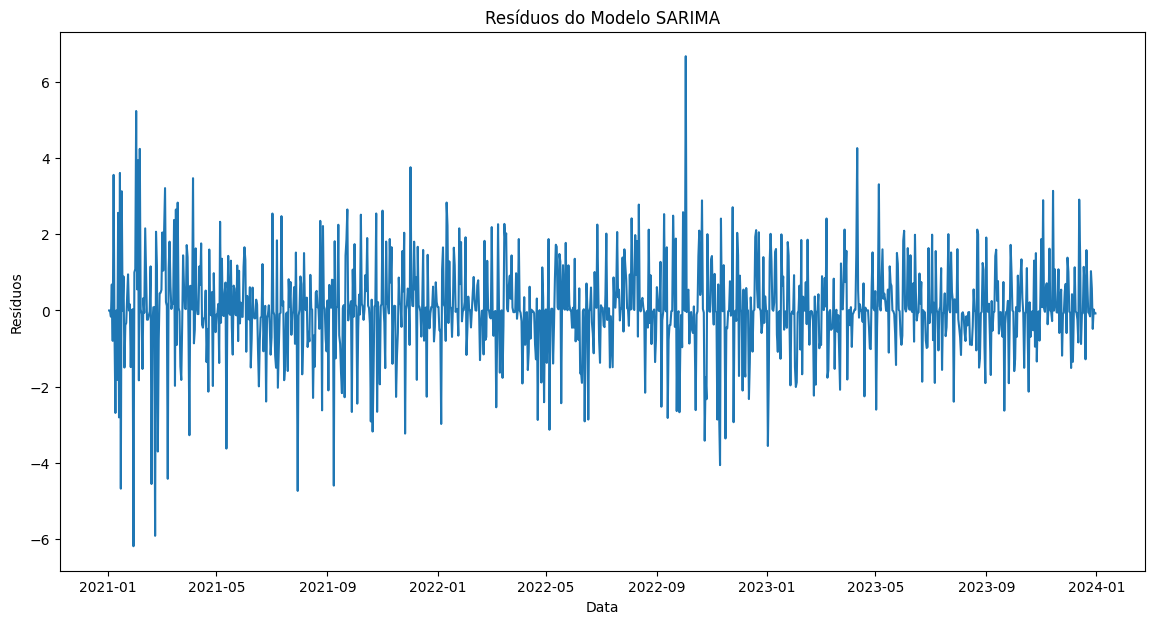

      lb_stat  lb_pvalue
10  13.545507    0.19475


In [65]:
# Resíduos do modelo SARIMA
resid_sarima = resultado_sarima.resid

# Plot dos resíduos
plt.figure(figsize=(14, 7))
plt.plot(resid_sarima)
plt.title("Resíduos do Modelo SARIMA")
plt.xlabel("Data")
plt.ylabel("Resíduos")
plt.show()

# Teste de Ljung-Box
lb_test_sarima = acorr_ljungbox(resid_sarima, lags=[10], return_df=True)
print(lb_test_sarima)

In [66]:
# Avaliação do modelo *** Resultado com foco no resultado do print

mae_sarima = mean_absolute_error(df_arima_valid, forecast_sarima_train)
print(f'MAE sarima : {mae_sarima}')

rmse_sarima = root_mean_squared_error(df_arima_valid, forecast_sarima_train)
print(f'rmse sarima : {rmse_sarima}')

mape_sarima = mean_absolute_percentage_error(df_arima_valid, forecast_sarima_train)
print(f'MAPE sarima : {mape_sarima}')

mse_sarima = mean_squared_error(df_arima_valid, forecast_sarima_train)
print(f'MSE sarima : {mse_sarima}')

r2_sarima = r2_score(df_arima_valid, forecast_sarima_train)
print(f'R² sarima : {r2_sarima}')

MAE sarima : 131.7123315795186
rmse sarima : 131.71545126367053
MAPE sarima : 0.9994072711825925
MSE sarima : 17348.96010159237
R² sarima : -20238.986732756293


### 4.6 - Prophet

In [67]:
datas_completas = pd.date_range(start=indice_ibov.index.min(), end=indice_ibov.index.max(), freq= 'D')
indice_ibov = indice_ibov.reindex(datas_completas)
indice_ibov.index.name = 'Data'

# Visualizar os primeiros registros
indice_ibov.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,"115,64M","-1,81%"
2005-01-04,24.848,25.722,25.873,24.791,"146,14M","-3,40%"
2005-01-05,24.692,24.859,25.001,24.523,"127,42M","-0,63%"
2005-01-06,24.367,24.695,24.808,24.250,"151,17M","-1,32%"
2005-01-07,24.747,24.376,24.874,24.376,"104,96M","1,56%"


In [68]:
indice_ibov = indice_ibov.fillna(method='ffill')

In [69]:
indice_ibov.head(2)


,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,"115,64M","-1,81%"
2005-01-04,24.848,25.722,25.873,24.791,"146,14M","-3,40%"


In [70]:
indice_ibov['Vol.'] = indice_ibov['Vol.'].str.replace(',', '', regex=False)
indice_ibov['Vol.'] = indice_ibov['Vol.'].str.replace('M', '0000', regex=False)
indice_ibov['Vol.'] = indice_ibov['Vol.'].str.replace('K', '', regex=False)
indice_ibov['Var%'] = indice_ibov['Var%'].str.replace('%', '', regex=False)
indice_ibov['Var%'] = indice_ibov['Var%'].str.replace(',', '.', regex=False)


# Verificando os primeiros valores para verificação
indice_ibov.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-12-26,121.078,120.767,121.612,120.428,8340000,0.26
2024-12-27,120.269,121.078,121.609,120.252,8940000,-0.67
2024-12-28,120.269,121.078,121.609,120.252,8940000,-0.67
2024-12-29,120.269,121.078,121.609,120.252,8940000,-0.67
2024-12-30,120.283,120.267,121.050,120.158,8900000,0.01


In [71]:
df_novo = indice_ibov
df_novo = df_novo.reset_index()
df_novo['unique_id'] = 0
df_pf = df_novo[['unique_id','Data', 'Abertura', 'Último', 'Máxima', 'Mínima', 'Vol.', 'Var%' ]]
df_novo = df_novo[['unique_id','Data','Abertura', 'Último', 'Máxima', 'Mínima', 'Vol.', 'Var%' ]]

In [72]:
df_pf.rename({"Último": "fechamento"}, inplace=True, axis=1)
df_pf.rename({"Abertura": "abertura"}, inplace=True, axis=1)
df_pf.rename({"Máxima": "alta"}, inplace=True, axis=1)
df_pf.rename({"Mínima": "baixa"}, inplace=True, axis=1)
df_pf.rename({"Vol.": "vol"}, inplace=True, axis=1)
df_pf.rename({"Var%": "var%"}, inplace=True, axis=1)

Executando o Propet

In [73]:
df_pf.head()

,unique_id,Data,abertura,fechamento,alta,baixa,vol,var%
0,0,2005-01-03,26.193,25.722,26.492,25.671,115640000,-1.81
1,0,2005-01-04,25.722,24.848,25.873,24.791,146140000,-3.40
2,0,2005-01-05,24.859,24.692,25.001,24.523,127420000,-0.63
3,0,2005-01-06,24.695,24.367,24.808,24.250,151170000,-1.32
4,0,2005-01-07,24.376,24.747,24.874,24.376,104960000,1.56


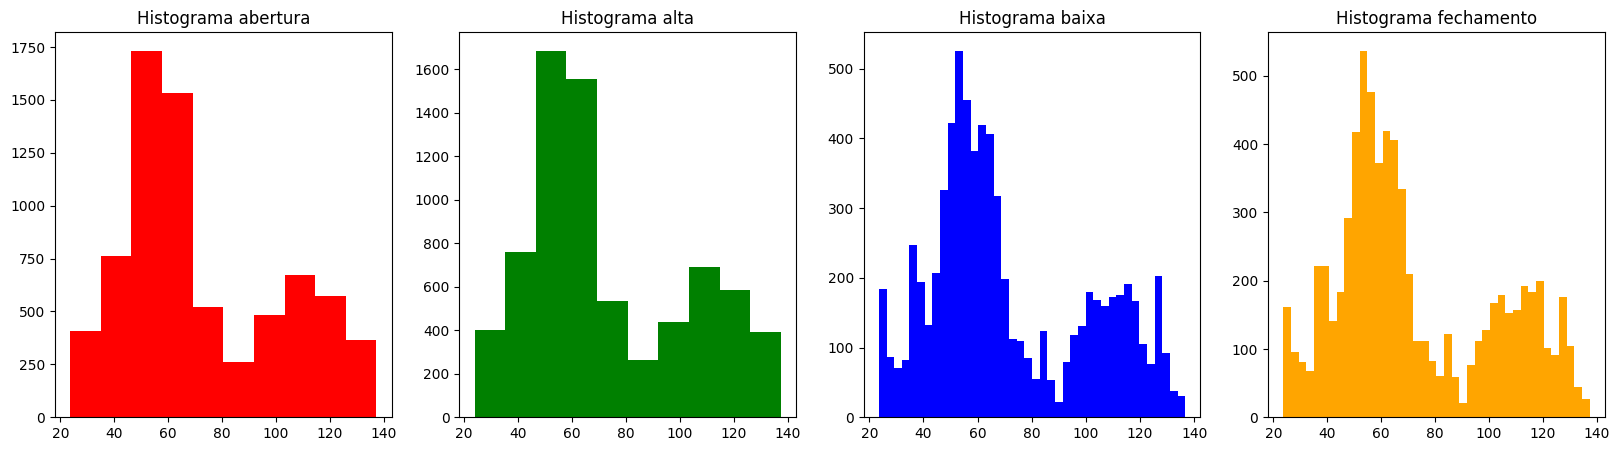

In [74]:
#new_fig = plt.figure(figsize=(18,8))
new_fig = plt.figure(figsize=(20,5))

#((5,4), (0,0))
ax1 = plt.subplot2grid((1,4), (0,0))
ax2 = plt.subplot2grid((1,4), (0,1))
ax3 = plt.subplot2grid((1,4), (0,2))
ax4 = plt.subplot2grid((1,4), (0,3))

ax1.hist(df_pf['abertura'], color='red',bins=10)
ax2.hist(df_pf['alta'], color='green',bins=10)
ax3.hist(df_pf['baixa'], color='blue',bins=40);
ax4.hist(df_pf['fechamento'], color='orange',bins=40)

ax1.set_title('Histograma abertura')
ax2.set_title('Histograma alta')
ax3.set_title('Histograma baixa')
ax4.set_title('Histograma fechamento')

plt.show()

In [75]:
historico = df_pf.copy()

def rolling_column_std( df, column_name, days,exclude=True ):
    column_name_hist = "std_%s_%sd" % (column_name, days)
    df[column_name_hist] = df[column_name].rolling(days).std().round(2)
    if exclude:
        df.drop([column_name], axis='columns', inplace=True)

rolling_column_std(historico,'abertura', 5, False)
rolling_column_std(historico,'fechamento', 5, False)
rolling_column_std(historico,'vol', 5, False)
rolling_column_std(historico,'alta', 5, False)
rolling_column_std(historico,'baixa', 5, False)

rolling_column_std(historico,'abertura', 10, False)
rolling_column_std(historico,'fechamento', 10, False)
rolling_column_std(historico,'vol', 10, False)
rolling_column_std(historico,'alta', 10, False)
rolling_column_std(historico,'baixa', 10,  False)

historico

,unique_id,Data,abertura,fechamento,alta,baixa,vol,var%,std_abertura_5d,std_fechamento_5d,std_vol_5d,std_alta_5d,std_baixa_5d,std_abertura_10d,std_fechamento_10d,std_vol_10d,std_alta_10d,std_baixa_10d
0,0,2005-01-03,26.193,25.722,26.492,25.671,115640000,-1.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2005-01-04,25.722,24.848,25.873,24.791,146140000,-3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2005-01-05,24.859,24.692,25.001,24.523,127420000,-0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2005-01-06,24.695,24.367,24.808,24.250,151170000,-1.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2005-01-07,24.376,24.747,24.874,24.376,104960000,1.56,0.76,0.51,19647991.75,0.74,0.57,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7297,0,2024-12-26,120.767,121.078,121.612,120.428,8340000,0.26,0.64,0.58,3901010.13,0.24,0.10,1.28,1.23,4433083.20,1.27,0.94
7298,0,2024-12-27,121.078,120.269,121.609,120.252,8940000,-0.67,0.66,0.29,748217.88,0.27,0.16,1.17,0.67,4576595.53,0.89,0.16
7299,0,2024-12-28,121.078,120.269,121.609,120.252,8940000,-0.67,0.63,0.35,706562.10,0.27,0.18,0.54,0.72,4197478.61,0.27,0.19
7300,0,2024-12-29,121.078,120.269,121.609,120.252,8940000,-0.67,0.51,0.37,580189.62,0.22,0.16,0.51,0.77,4304888.69,0.29,0.20


In [76]:
historico.isnull().sum()

unique_id             0
Data                  0
abertura              0
fechamento            0
alta                  0
baixa                 0
vol                   0
var%                  0
std_abertura_5d       4
std_fechamento_5d     4
std_vol_5d            4
std_alta_5d           4
std_baixa_5d          4
std_abertura_10d      9
std_fechamento_10d    9
std_vol_10d           9
std_alta_10d          9
std_baixa_10d         9
dtype: int64

In [77]:
historico.dropna(subset=['std_abertura_5d'], inplace=True)
historico.dropna(subset=['std_abertura_10d'], inplace=True)
historico.dropna(subset=['std_fechamento_5d'], inplace=True)
historico.dropna(subset=['std_fechamento_10d'], inplace=True)
historico.isnull().sum()

unique_id             0
Data                  0
abertura              0
fechamento            0
alta                  0
baixa                 0
vol                   0
var%                  0
std_abertura_5d       0
std_fechamento_5d     0
std_vol_5d            0
std_alta_5d           0
std_baixa_5d          0
std_abertura_10d      0
std_fechamento_10d    0
std_vol_10d           0
std_alta_10d          0
std_baixa_10d         0
dtype: int64

In [78]:
historico_goog = historico.reset_index()

historico_goog.rename({"Data": "ds"}, inplace=True, axis=1)
historico_goog.rename({"fechamento": "y"}, inplace=True, axis=1)

print(historico_goog)

      index  unique_id         ds  abertura        y     alta    baixa  \
0         9          0 2005-01-12    24.370   24.510   24.560   23.983   
1        10          0 2005-01-13    24.523   24.806   24.919   24.523   
2        11          0 2005-01-14    24.802   24.924   24.966   24.481   
3        12          0 2005-01-15    24.802   24.924   24.966   24.481   
4        13          0 2005-01-16    24.802   24.924   24.966   24.481   
...     ...        ...        ...       ...      ...      ...      ...   
7288   7297          0 2024-12-26   120.767  121.078  121.612  120.428   
7289   7298          0 2024-12-27   121.078  120.269  121.609  120.252   
7290   7299          0 2024-12-28   121.078  120.269  121.609  120.252   
7291   7300          0 2024-12-29   121.078  120.269  121.609  120.252   
7292   7301          0 2024-12-30   120.267  120.283  121.050  120.158   

            vol   var%  std_abertura_5d  std_fechamento_5d   std_vol_5d  \
0     107120000   0.57             0

In [79]:
# Definição de período de Treino e validação ***

train = historico_goog.loc[(df['ds'] >= '2021-01-01') & (historico_goog['ds'] < '2024-01-16')]

test = historico_goog.loc[(df['ds'] >= '2024-01-01') & (historico_goog['ds'] < '2024-01-16')]

h = valid['ds'].nunique() # Quantidade de dias a serem previstos

20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing


WMAPE para os últimos 15 dias: 0.03685780602297448


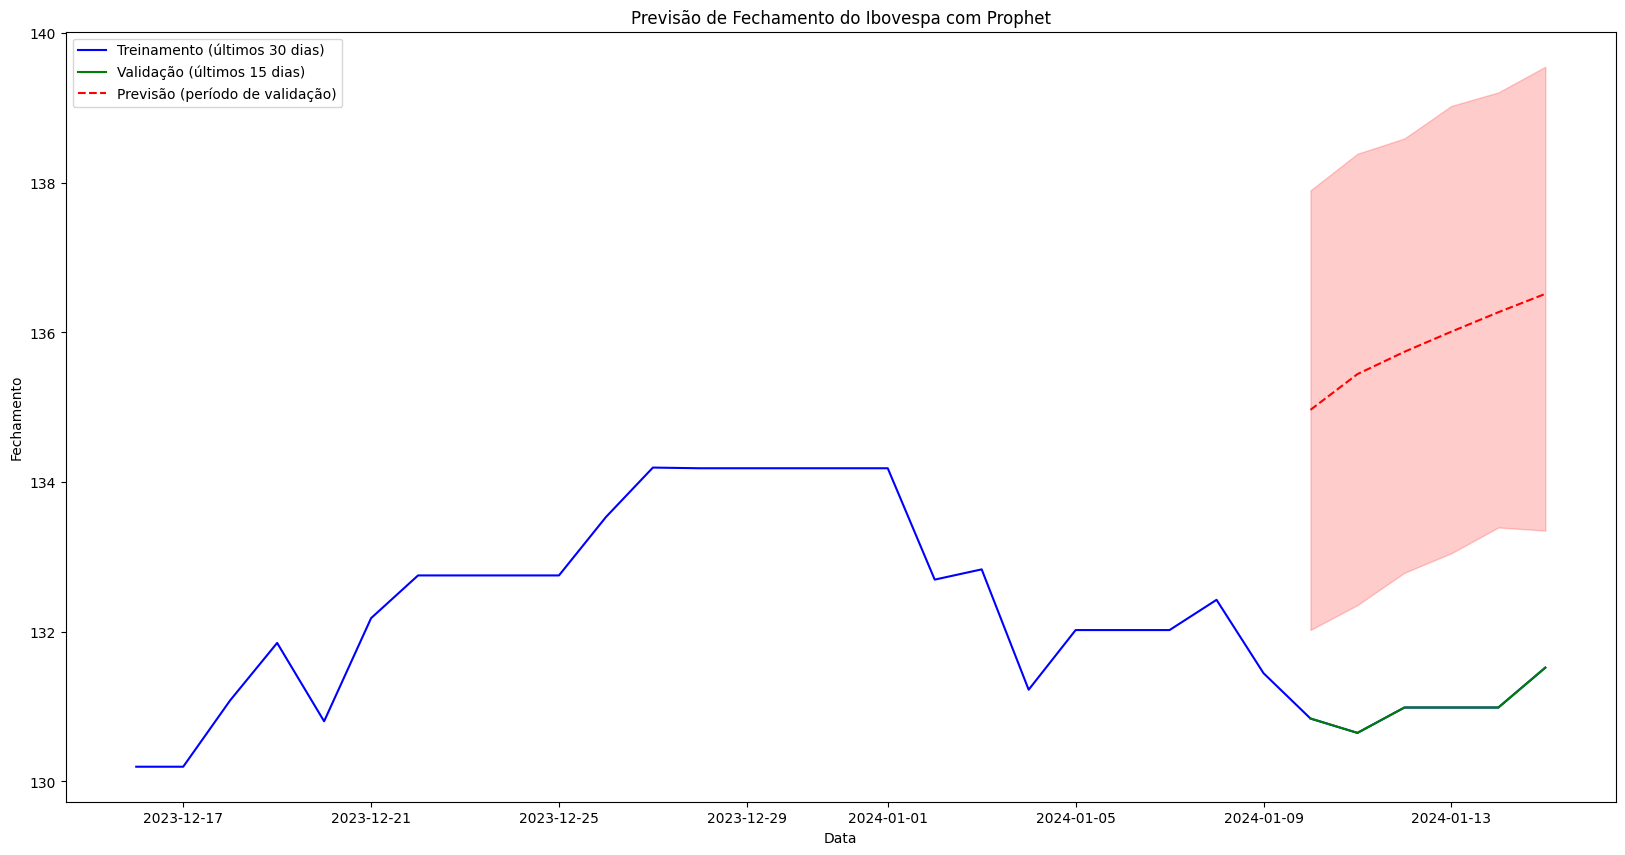

In [80]:
# Treine o modelo com os dados de treino
m = Prophet()

# Adicionando regressores
for reg in ['std_abertura_5d', 'std_fechamento_5d', 'std_vol_5d', 'std_alta_5d', 'std_baixa_5d',
            'std_abertura_10d', 'std_fechamento_10d', 'std_vol_10d', 'std_alta_10d', 'std_baixa_10d']:
    m.add_regressor(reg)

# Remover valores nulos
train = train.dropna(subset=['std_vol_5d', 'std_vol_10d'])

# Ajustar o modelo com os dados de treino
m.fit(train)

# Criar dataframe com as datas futuras (15 dias à frente)
future = m.make_future_dataframe(periods=15)

# Adicionar os valores futuros dos regressores
last_row = train.iloc[-1]
for reg in ['std_abertura_5d', 'std_fechamento_5d', 'std_vol_5d', 'std_alta_5d', 'std_baixa_5d',
            'std_abertura_10d', 'std_fechamento_10d', 'std_vol_10d', 'std_alta_10d', 'std_baixa_10d']:
    future[reg] = last_row[reg]

# Prever os próximos 15 dias
forecast = m.predict(future)

# Calcular WMAPE
df_comparacao = pd.merge(forecast[['ds', 'yhat']], test[['ds', 'y']], on='ds', how='inner')
df_comparacao['abs_error'] = abs(df_comparacao['y'] - df_comparacao['yhat'])
wmape = df_comparacao['abs_error'].sum() / df_comparacao['y'].sum()

print(f"WMAPE para os últimos 15 dias: {wmape}")

# Filtrar os últimos 30 dias do treino
last_30_days = train['ds'].max() - pd.Timedelta(days=30)
train_subset = train[train['ds'] >= last_30_days]

# Filtrar previsões para o período de validação ( 15 dias)
forecast_validation = forecast[forecast['ds'].isin(test['ds'])]

# Gráfico
plt.figure(figsize=(20, 10))

# Dados históricos (últimos 30 dias do treino)
plt.plot(train_subset['ds'], train_subset['y'], label='Treinamento (últimos 30 dias)', color='blue')

# Dados de teste (validação)
plt.plot(test['ds'], test['y'], label='Validação (últimos 15 dias)', color='green')

# Previsão do modelo (somente período de validação)
plt.plot(forecast_validation['ds'], forecast_validation['yhat'], label='Previsão (período de validação)', color='red', linestyle='--')

# Intervalos de confiança (somente período de validação)
plt.fill_between(forecast_validation['ds'], forecast_validation['yhat_lower'], forecast_validation['yhat_upper'], color='red', alpha=0.2)

# Rótulos e título
plt.title('Previsão de Fechamento do Ibovespa com Prophet')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()

# Exibir o gráfico
plt.show()

In [82]:
# Calculando as métricas de avaliação
mae = mean_absolute_error(test['y'], forecast_validation['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_validation['yhat']))
mape = mean_absolute_percentage_error(test['y'], forecast_validation['yhat'])
mse = mean_squared_error(test['y'], forecast_validation['yhat'])
r2 = r2_score(test['y'], forecast_validation['yhat'])

# Exibindo as métricas
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape:.2f}%')
print(f"WMAPE: {wmape}")
print(f'MSE: {mse}')
print(f'R²: {r2}')

MAE: 4.828219014817894
RMSE: 4.8415400163985
MAPE: 0.04%
WMAPE: 0.03685780602297448
MSE: 23.440509730387983
R²: -333.66455561024145
